1. define exact regression line: 
    * $y^0 = f(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2$
2. define regression
    * $y = f(x) + \varepsilon(x)$
    * $\varepsilon(x)$ - not correlated errors with mean 0
    * where $ -1 \le x_1, x_2 \le 1$
    * $D(\varepsilon(x)) = D(\varepsilon(x_1, x_2)) = d(x_1, x_2)$
2. say, we are going to do experiment in 3 points: $x^{(1)} = (1, 1), x^{(2)} = (-1, 1), x^{(3)} = (-1, -1)$
3. set a-priori dispersions $d(x^{(1)}) = d_1, d(x^{(2)}) = d_2, d(x^{(3)}) = d_3$
4. according to the theorem, these must fullfill to create $D$-optimal plan:
    * $d(x_1, x_2) \ge d_{lower}(x_1, x_2)$, where
    * $d_{lower}(x_1, x_2) = \frac 1 4 (d_1 + d_3 + 2 d_1 x_1 - 2 d_3 x_2 - 2 d_2 x_1 x_2 + (d_1 + d_2)x_1^2 + (d_2 + d_3)x_2^2)$
    * $d(x^{(i)}) = d_{lower}(x^{(i)}) = d_i, i = \overline{1, 3}$
    
simulation:

0. f(x)
    * set $\theta_0, \theta_1, \theta_2$
    * implement f(x)
1. set $d_1, d_2, d_3$
2. generate $N$ points $(x_1, x_2)^{(i)} = x^{(i)}, i = \overline {1 ,N}$ from $R^2[0, 1]$
3. generate $\varepsilon_i$ from $N(0, d_{lower}(x^{(i)}; d_1, d_2, d_3)), i = \overline{1, N}$
4. generate $y_i = f(x^{(i)}) + \varepsilon_i$

test plan:

1. set N
2. generate experiment design with N/3 observations in each point
3. estimate $\hat \theta$ via WLS
4. compare optimal design estimates with random design estimates

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
thetas = np.array([2, 5, 1])
def f(X):
    return np.dot(X, thetas)

d1, d2, d3 = 6, 4 , 2

def d_lower(x1, x2, d1, d2, d3):
    return 1/4 * (d1 + d3 + 2*d1*x2 - 2*d3*x2 - 2*d2*x2 + (d1 + d2)*x1**2 + (d2 + d2)*x2**2)

In [3]:
points = np.array([
    [1, 1],
    [-1, 1],
    [-1, -1]
])

In [4]:
n_trials = 5
results = []

np.random.seed(42)

def make_y(X):
    N = X.shape[0]
    error_dispersions = d_lower(X[:, 1], X[:, 2], d1, d2, d3)
    errors = np.random.normal(0, np.sqrt(error_dispersions), N)
    return f(X) + errors 

Ns = np.arange(1, 10) * 3
for _ in range(n_trials):
    for N in Ns:
        result = {
            'N': N
        }
        Xs = [
            ('optimal', np.repeat(points, N / 3, axis=0)),
            ('random', np.random.uniform(-1, 1, (N, 2)))
        ]
        for name, X in Xs:
            X = np.concatenate([np.ones((N, 1)), X], axis=1)
            y = make_y(X)
            error_dispersions = d_lower(X[:, 1], X[:, 2], d1, d2, d3)
            weights = 1 / error_dispersions
            wls_estimator = LinearRegression(fit_intercept=False).fit(X, y, weights)
            result[f'theta_{name}_mse'] = mean_squared_error(thetas, wls_estimator.coef_)
        results.append(result)
    
df = pd.DataFrame(results)

In [24]:
df_agg = df.groupby('N').agg(['mean', 'std'])
df_agg.columns = [f'{agg_name}_{column}' for (column, agg_name) in df_agg.columns]

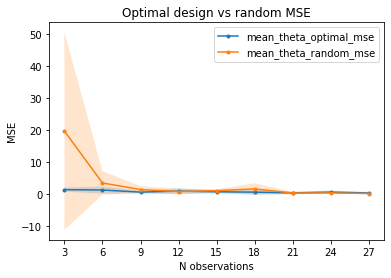

In [53]:
ax = plt.gca()
for name in ['optimal', 'random']:
    mean = df_agg[f'mean_theta_{name}_mse'].values
    ax.plot(Ns, mean, '.-', label=f'mean_theta_{name}_mse') 
    mean = df_agg[f'mean_theta_{name}_mse']
    std = df_agg[f'std_theta_{name}_mse']
    ax.fill_between(Ns, mean - std, mean + std, alpha=0.2)
ax.legend()
ax.set_title('Optimal design vs random MSE')
ax.set_xticks(Ns)
ax.set_xticklabels(Ns);
ax.set_xlabel('N observations')
ax.set_ylabel('MSE');

In [63]:
df_agg[['mean_theta_optimal_mse', 'mean_theta_random_mse']].round(2).to_latex('heteroscedastic_experiment_results.tex')